In [1]:
%pip install numpy pandas matplotlib scikit-learn tensorflow openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install tensorflow --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [8]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [9]:
df = pd.read_excel('Gold_data_filtered.xlsx')
df=df.set_index(pd.DatetimeIndex(df['date'].values))

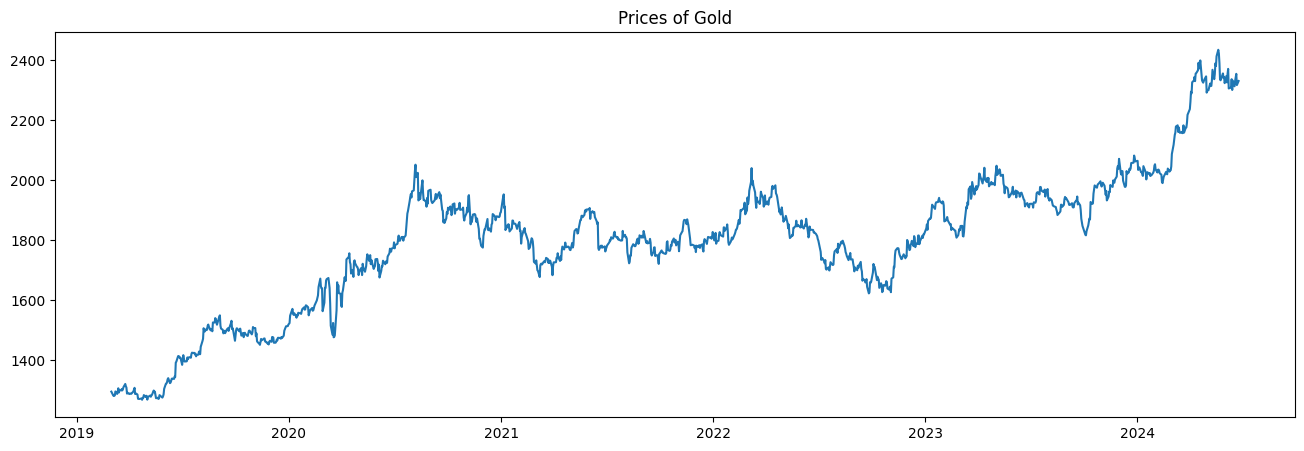

In [10]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float


# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['date', 'close'])
df1.drop('date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['close'])
plt.title('Prices of Gold')
plt.show()

In [10]:
df

,date,open,high,low,close,volume
2019-03-01,2019-03-01,1312.199951,1312.199951,1288.900024,1296.400024,110
2019-03-04,2019-03-04,1285.500000,1287.000000,1281.900024,1284.800049,28
2019-03-05,2019-03-05,1287.000000,1287.000000,1282.000000,1282.000000,114
2019-03-06,2019-03-06,1287.099976,1287.099976,1282.599976,1284.900024,14
2019-03-07,2019-03-07,1281.000000,1284.599976,1281.000000,1283.800049,11
...,...,...,...,...,...,...
2024-06-17,2024-06-17,2320.199951,2320.199951,2309.600098,2312.399902,110
2024-06-18,2024-06-18,2311.800049,2330.399902,2311.800049,2330.399902,43
2024-06-20,2024-06-20,2328.899902,2354.000000,2328.300049,2353.800049,183
2024-06-21,2024-06-21,2331.199951,2331.199951,2316.399902,2316.399902,76


In [11]:
# Split dataset 

In [12]:
# Create a MinMaxScaler object with a specified range
data = df1.values
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

# Split the data
train_size = int(0.7 * len(sc_train))
test_size = int(0.2 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [14]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(100, len(train_data)):
    # Append the last 100 values to the x_train array
    x_train.append(sc_train[i-100:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [15]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [17]:
# Build the model
model = Sequential()

# Add an LSTM layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Add an LSTM layer with 50 units
model.add(LSTM(50,return_sequences=True))

# Add an LSTM layer with 50 units
model.add(LSTM(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_7_2_1.keras'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.16532, saving model to save_model_7_2_1.keras
17/17 - 3s - 192ms/step - loss: 0.1653
Epoch 2/80

Epoch 2: loss improved from 0.16532 to 0.04838, saving model to save_model_7_2_1.keras
17/17 - 1s - 45ms/step - loss: 0.0484
Epoch 3/80

Epoch 3: loss improved from 0.04838 to 0.04314, saving model to save_model_7_2_1.keras
17/17 - 1s - 48ms/step - loss: 0.0431
Epoch 4/80

Epoch 4: loss improved from 0.04314 to 0.03859, saving model to save_model_7_2_1.keras
17/17 - 1s - 50ms/step - loss: 0.0386
Epoch 5/80

Epoch 5: loss improved from 0.03859 to 0.03298, saving model to save_model_7_2_1.keras
17/17 - 1s - 46ms/step - loss: 0.0330
Epoch 6/80

Epoch 6: loss improved from 0.03298 to 0.03240, saving model to save_model_7_2_1.keras
17/17 - 1s - 46ms/step - loss: 0.0324
Epoch 7/80

Epoch 7: loss improved from 0.03240 to 0.03098, saving model to save_model_7_2_1.keras
17/17 - 1s - 46ms/step - loss: 0.0310
Epoch 8/80

Epoch 8: loss did not improve fr

In [19]:
from keras.models import load_model

# Reshape y_train to 2D if it's 1D, as MinMaxScaler expects 2D input
y_train = y_train.reshape(-1, 1)

# Transform the y_train array back to the original scale
y_train_original = sc.inverse_transform(y_train)

# Load the best model from the save_model.keras file
final_model = load_model('save_model_7_2_1.keras')  # Đảm bảo đuôi đúng như đã lưu

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict_original = sc.inverse_transform(y_train_predict)

# Kiểm tra kết quả
print(f"Original y_train shape: {y_train_original.shape}")
print(f"Predicted y_train shape: {y_train_predict_original.shape}")


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Original y_train shape: (837, 1)
Predicted y_train shape: (837, 1)


In [20]:
# Preprocess the test data
test = df1[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [21]:
# Preprocess the validate data
val = df1[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [22]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 100)
[0.1294864723729674, 0.13395158820351583, 0.13377979250769556, 0.13463845653464124, 0.13051693209573356, 0.12012701351578259, 0.1220161372654942, 0.1207281412250758, 0.11591964363765794, 0.1208998321035113, 0.11008068632747348, 0.10965135431400053, 0.1093937131789624, 0.1274256577448203, 0.1161771799553104, 0.09986256344334365, 0.12055634552925554, 0.1194401451846574, 0.1221878281439297, 0.12502146135980396, 0.12450628390711405, 0.10896438116548968, 0.1061308527670004, 0.06465733833857357, 0.0663746663924647, 0.0595911996161167, 0.06079335021731813, 0.060020531629589646, 0.05375234712331789, 0.049029694975117, 0.04756990323887811, 0.06173785968348078, 0.05864669014995427, 0.05066117758979116, 0.04645370289428019, 0.04585257518498698, 0.031341236983514875, 0.015284156789200587, 0.009702840614054242, 0.006182339067053899, 0.011763655242200466, 0.013309292417656993, 0.003692192425434726, 0.002318350945798686, 0.005838852492798807, 0.004465011013162767, 0.013480983296091598, 0.023

In [23]:
# Initialize variables
lst_output = []
n_steps = 100
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 100):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.06256487965583801], [0.06741645932197571], [0.07564398646354675], [0.08525437116622925], [0.09495657682418823], [0.10417494177818298], [0.11276160180568695], [0.12075519561767578], [0.1282477229833603], [0.13533024489879608], [0.14207734167575836], [0.1485462188720703], [0.15477976202964783], [0.16080933809280396], [0.16665738821029663], [0.17233973741531372], [0.177867591381073], [0.18324916064739227], [0.1884908229112625], [0.1935979425907135], [0.19857582449913025], [0.20342925190925598], [0.20816339552402496], [0.21278315782546997], [0.21729344129562378], [0.22169890999794006], [0.22600390017032623], [0.23021234571933746], [0.2343277782201767], [0.23835331201553345]]


In [26]:
# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['date'].astype(str).tolist()


# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]


# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

In [27]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[1342.16309851]
 [1347.81324748]
 [1357.39502438]
 [1368.587277  ]
 [1379.88646429]
 [1390.62217076]
 [1400.62219377]
 [1409.93153196]
 [1418.65732823]
 [1426.90563221]
 [1434.76330013]
 [1442.29695357]
 [1449.55653702]
 [1456.57858041]
 [1463.38921873]
 [1470.00688178]
 [1476.4446197 ]
 [1482.71199447]
 [1488.81643358]
 [1494.76418441]
 [1500.56142495]
 [1506.2137258 ]
 [1511.72710876]
 [1517.10728326]
 [1522.35995873]
 [1527.49056694]
 [1532.50415786]
 [1537.40531293]
 [1542.19814502]
 [1546.88628109]]


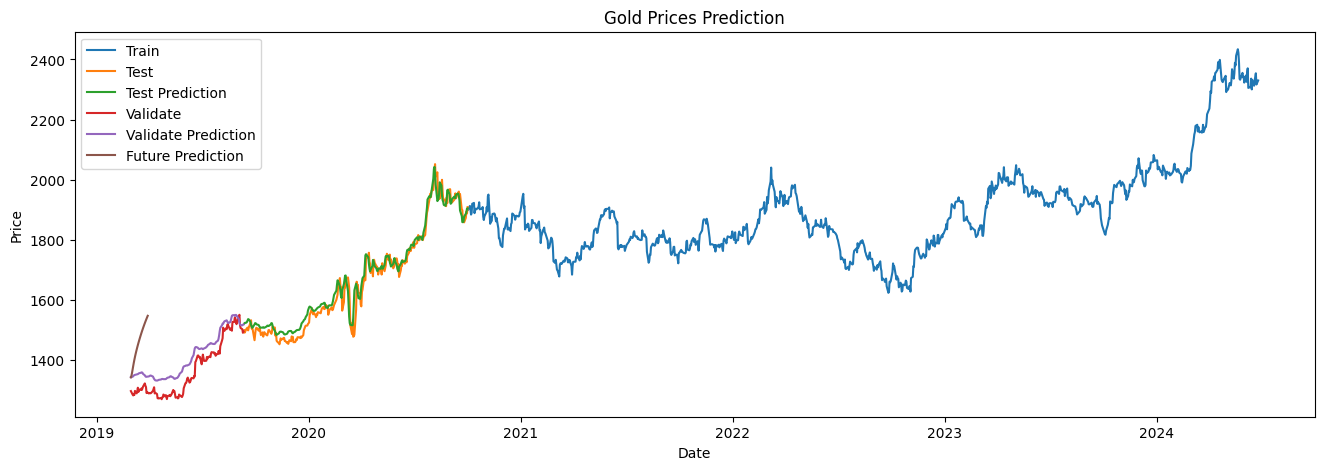

In [ ]:
import matplotlib.pyplot as plt


df1 = df1.rename(columns={'close': 'Price'})

# Inverse transform lst_output
y_pred_future = sc.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Create a DataFrame for future predictions
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price'])
PREDICTIONS_FUTURE['date'] = datelist_future
PREDICTIONS_FUTURE.set_index('date', inplace=True)

# Define data for plotting
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Plotting
plt.figure(figsize=(16, 5))

# Plot training data
plt.plot(train_data.index, train_data['Price'], label='Train')

# Plot test data and its prediction
plt.plot(test_data.index, test_data['Price'], label='Test')
plt.plot(test_data.index, y_test_predict, label='Test Prediction')

# Plot validation data and its prediction
plt.plot(val_data.index, val_data['Price'], label='Validate')
plt.plot(val_data.index, y_val_predict, label='Validate Prediction')

# Plot future predictions
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['price'], label='Future Prediction')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend()
plt.show()


In [36]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  22.40116465136349
MAPE:  1.3820193706257664
RMSE:  29.341339863639305

** Validate **
MAE:  46.442211914062476
MAPE:  3.4788999353233803
RMSE:  50.12424647286718


In [37]:
# Split dataset 6-3-1

In [38]:
#  Split data (6-3-1)
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [39]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(100, len(train_data)):
    # Append the last 100 values to the x_train array
    x_train.append(sc_train[i-100:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:

# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
import numpy as np


x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  

# Build the model
model = Sequential()

# Add LSTM layers
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))

# Add Dense output layer
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_absolute_error', optimizer='adam')

# Set the filename to use for saving the best model
save_model = 'save_model_6_3_1.keras'

# Create a ModelCheckpoint callback to save the best model based on 'loss'
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])


Epoch 1/80


c:\Users\Ken\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.13205, saving model to save_model_6_3_1.keras
15/15 - 3s - 189ms/step - loss: 0.1321
Epoch 2/80

Epoch 2: loss improved from 0.13205 to 0.04792, saving model to save_model_6_3_1.keras
15/15 - 1s - 45ms/step - loss: 0.0479
Epoch 3/80

Epoch 3: loss improved from 0.04792 to 0.04445, saving model to save_model_6_3_1.keras
15/15 - 1s - 45ms/step - loss: 0.0445
Epoch 4/80

Epoch 4: loss improved from 0.04445 to 0.03715, saving model to save_model_6_3_1.keras
15/15 - 1s - 46ms/step - loss: 0.0371
Epoch 5/80

Epoch 5: loss improved from 0.03715 to 0.03415, saving model to save_model_6_3_1.keras
15/15 - 1s - 46ms/step - loss: 0.0342
Epoch 6/80

Epoch 6: loss improved from 0.03415 to 0.03336, saving model to save_model_6_3_1.keras
15/15 - 1s - 45ms/step - loss: 0.0334
Epoch 7/80

Epoch 7: loss did not improve from 0.03336
15/15 - 1s - 43ms/step - loss: 0.0334
Epoch 8/80

Epoch 8: loss did not improve from 0.03336
15/15 - 1s - 44ms/step - loss: 0.0379
Epoch 

In [45]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.keras file
final_model = load_model('save_model_6_3_1.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [46]:
# Preprocess the test data
test = df1[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [47]:
# Preprocess the validate data
val = df1[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [48]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 100)
[0.1294864723729674, 0.13395158820351583, 0.13377979250769556, 0.13463845653464124, 0.13051693209573356, 0.12012701351578259, 0.1220161372654942, 0.1207281412250758, 0.11591964363765794, 0.1208998321035113, 0.11008068632747348, 0.10965135431400053, 0.1093937131789624, 0.1274256577448203, 0.1161771799553104, 0.09986256344334365, 0.12055634552925554, 0.1194401451846574, 0.1221878281439297, 0.12502146135980396, 0.12450628390711405, 0.10896438116548968, 0.1061308527670004, 0.06465733833857357, 0.0663746663924647, 0.0595911996161167, 0.06079335021731813, 0.060020531629589646, 0.05375234712331789, 0.049029694975117, 0.04756990323887811, 0.06173785968348078, 0.05864669014995427, 0.05066117758979116, 0.04645370289428019, 0.04585257518498698, 0.031341236983514875, 0.015284156789200587, 0.009702840614054242, 0.006182339067053899, 0.011763655242200466, 0.013309292417656993, 0.003692192425434726, 0.002318350945798686, 0.005838852492798807, 0.004465011013162767, 0.013480983296091598, 0.023

In [49]:
# Initialize variables
lst_output = []
n_steps = 100
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 100):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.06606663018465042], [0.06965138018131256], [0.07657944411039352], [0.0852089673280716], [0.09425362944602966], [0.10303109139204025], [0.11129645258188248], [0.11902771890163422], [0.12628386914730072], [0.13313697278499603], [0.13964980840682983], [0.14587225019931793], [0.15184339880943298], [0.15759435296058655], [0.16314981877803802], [0.16852976381778717], [0.17375032603740692], [0.17882484197616577], [0.18376438319683075], [0.18857860565185547], [0.19327588379383087], [0.19786371290683746], [0.2023487538099289], [0.20673714578151703], [0.21103408932685852], [0.2152441293001175], [0.2193712592124939], [0.223418727517128], [0.22738900780677795], [0.23128409683704376]]


In [50]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[1346.24123666]
 [1350.41603598]
 [1358.48445822]
 [1368.5343997 ]
 [1379.06781187]
 [1389.29004277]
 [1398.9158812 ]
 [1407.91971283]
 [1416.37022434]
 [1424.35134783]
 [1431.93619524]
 [1439.18285004]
 [1446.13684884]
 [1452.8344092 ]
 [1459.30430388]
 [1465.56978708]
 [1471.64965308]
 [1477.5594336 ]
 [1483.31202258]
 [1488.91866535]
 [1494.38911478]
 [1499.7320999 ]
 [1504.95537787]
 [1510.06609852]
 [1515.07031834]
 [1519.97333028]
 [1524.77978517]
 [1529.49346617]
 [1534.11725401]
 [1538.65347413]]


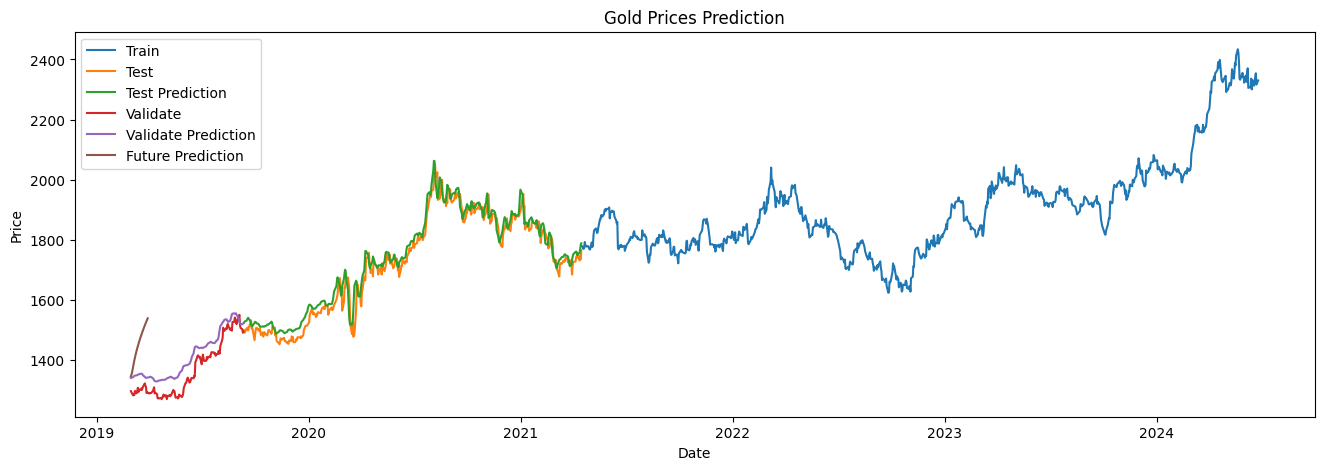

In [ ]:
plt.figure(figsize=(16, 5))

# Plot the training data
plt.plot(train_data.index, train_data['Price'], label='Train')  

# Plot the test data and its predictions
plt.plot(test_data.index, test_data['Price'], label='Test') 
plt.plot(test_data.index, y_test_predict, label='Test Prediction')

# Plot the validation data and its predictions
plt.plot(val_data.index, val_data['Price'], label='Validate') 
plt.plot(val_data.index, y_val_predict, label='Validate Prediction')

# Plot the future predictions
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['price'], label='Future Prediction')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend()
plt.show()


In [55]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  25.260882827111924
MAPE:  1.507206362702443
RMSE:  32.0958745598258

** Validate **
MAE:  47.43599717881942
MAPE:  3.540535899782594
RMSE:  50.801851585154964


In [56]:
# Split dataset 5-3-2 

In [57]:
# Split data
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [58]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(100, len(train_data)):
    # Append the last 100 values to the x_train array
    x_train.append(sc_train[i-100:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [59]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [60]:
# Build the model
model = Sequential()

# Add an LSTM layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Add an LSTM layer with 50 units
model.add(LSTM(50,return_sequences=True))

# Add an LSTM layer with 50 units
model.add(LSTM(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_5_3_2.keras'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80


c:\Users\Ken\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.22657, saving model to save_model_5_3_2.keras
12/12 - 3s - 252ms/step - loss: 0.2266
Epoch 2/80

Epoch 2: loss improved from 0.22657 to 0.05806, saving model to save_model_5_3_2.keras
12/12 - 1s - 48ms/step - loss: 0.0581
Epoch 3/80

Epoch 3: loss improved from 0.05806 to 0.04298, saving model to save_model_5_3_2.keras
12/12 - 1s - 47ms/step - loss: 0.0430
Epoch 4/80

Epoch 4: loss improved from 0.04298 to 0.03770, saving model to save_model_5_3_2.keras
12/12 - 1s - 46ms/step - loss: 0.0377
Epoch 5/80

Epoch 5: loss improved from 0.03770 to 0.03476, saving model to save_model_5_3_2.keras
12/12 - 1s - 47ms/step - loss: 0.0348
Epoch 6/80

Epoch 6: loss improved from 0.03476 to 0.03251, saving model to save_model_5_3_2.keras
12/12 - 1s - 47ms/step - loss: 0.0325
Epoch 7/80

Epoch 7: loss improved from 0.03251 to 0.03223, saving model to save_model_5_3_2.keras
12/12 - 1s - 47ms/step - loss: 0.0322
Epoch 8/80

Epoch 8: loss did not improve from 0.03223


In [62]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.keras file
final_model = load_model('save_model_5_3_2.keras')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [63]:
# Preprocess the test data
test = df1[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [64]:
# Preprocess the validate data
val = df1[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [65]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 100)
[0.1294864723729674, 0.13395158820351583, 0.13377979250769556, 0.13463845653464124, 0.13051693209573356, 0.12012701351578259, 0.1220161372654942, 0.1207281412250758, 0.11591964363765794, 0.1208998321035113, 0.11008068632747348, 0.10965135431400053, 0.1093937131789624, 0.1274256577448203, 0.1161771799553104, 0.09986256344334365, 0.12055634552925554, 0.1194401451846574, 0.1221878281439297, 0.12502146135980396, 0.12450628390711405, 0.10896438116548968, 0.1061308527670004, 0.06465733833857357, 0.0663746663924647, 0.0595911996161167, 0.06079335021731813, 0.060020531629589646, 0.05375234712331789, 0.049029694975117, 0.04756990323887811, 0.06173785968348078, 0.05864669014995427, 0.05066117758979116, 0.04645370289428019, 0.04585257518498698, 0.031341236983514875, 0.015284156789200587, 0.009702840614054242, 0.006182339067053899, 0.011763655242200466, 0.013309292417656993, 0.003692192425434726, 0.002318350945798686, 0.005838852492798807, 0.004465011013162767, 0.013480983296091598, 0.023

In [66]:
# Initialize variables
lst_output = []
n_steps = 100
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 100):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.0565241314470768], [0.05925513431429863], [0.06491956114768982], [0.07241015881299973], [0.08070138841867447], [0.08911829441785812], [0.09731215983629227], [0.1051480770111084], [0.1126006469130516], [0.11968658119440079], [0.12643109261989594], [0.13285550475120544], [0.1389755755662918], [0.14480310678482056], [0.1503480225801468], [0.1556195318698883], [0.16062720119953156], [0.16538092494010925], [0.16989126801490784], [0.17416925728321075], [0.17822666466236115], [0.18207548558712006], [0.1857282817363739], [0.18919776380062103], [0.19249655306339264], [0.19563713669776917], [0.19863171875476837], [0.2014918476343155], [0.2042285054922104], [0.20685182511806488]]


In [67]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[1335.12804403]
 [1338.30856957]
 [1344.90536023]
 [1353.62890917]
 [1363.28487396]
 [1373.08720145]
 [1382.62977592]
 [1391.75548391]
 [1400.43474573]
 [1408.68702375]
 [1416.54168077]
 [1424.0235502 ]
 [1431.15098377]
 [1437.93772578]
 [1444.3953339 ]
 [1450.53453285]
 [1456.36646382]
 [1461.90264979]
 [1467.15539467]
 [1472.13754035]
 [1476.86279639]
 [1481.34513267]
 [1485.59917853]
 [1489.63973684]
 [1493.48150633]
 [1497.13902957]
 [1500.62651939]
 [1503.95742507]
 [1507.14453641]
 [1510.19965406]]


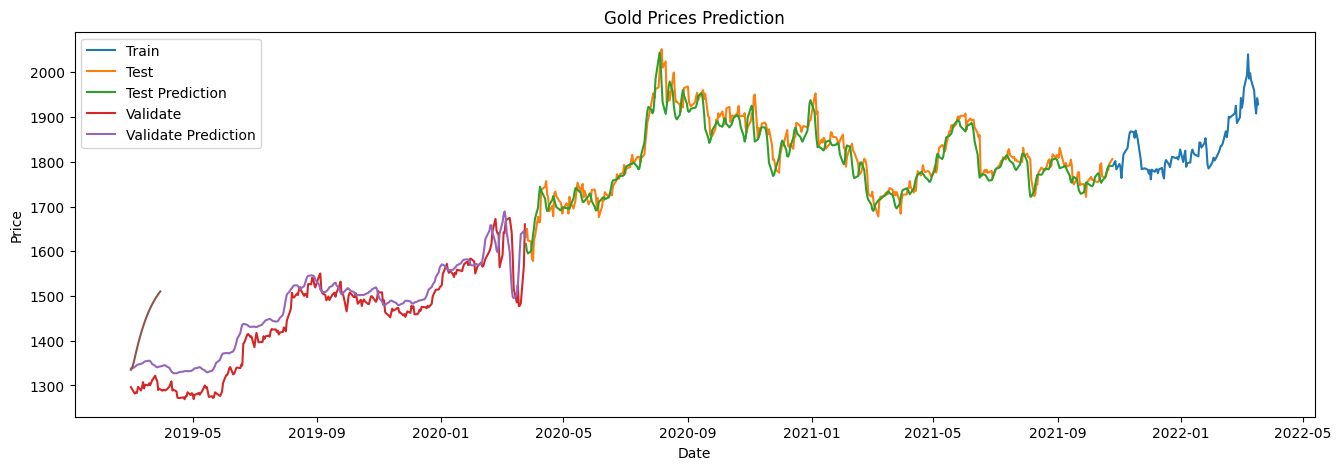

In [70]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [71]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  21.050031780899282
MAPE:  1.1532185643238446
RMSE:  28.073775785821063

** Validate **
MAE:  33.801719693889375
MAPE:  2.4095232329798573
RMSE:  41.2468636209663


In [75]:
import pandas as pd
data = {
    "Model": ["LSTM", "LSTM", "LSTM"],
    "Ratio": ["7-2-1", "6-3-1", "5-3-2"],
    "Testing MAE": [22.4012, 25.2609, 21.0500],
    "Testing MAPE": [1.3820, 1.5072, 1.1532],
    "Testing RMSE": [29.3413, 32.0959, 28.0738],
    "Validation MAE": [46.4422, 47.4360, 33.8017],
    "Validation MAPE": [3.4789, 3.5405, 2.4095],
    "Validation RMSE": [50.1242, 50.8019, 41.2469],
}


df = pd.DataFrame(data)


print(df.to_string(index=False))


Model Ratio  Testing MAE  Testing MAPE  Testing RMSE  Validation MAE  Validation MAPE  Validation RMSE
 LSTM 7-2-1      22.4012        1.3820       29.3413         46.4422           3.4789          50.1242
 LSTM 6-3-1      25.2609        1.5072       32.0959         47.4360           3.5405          50.8019
 LSTM 5-3-2      21.0500        1.1532       28.0738         33.8017           2.4095          41.2469
